In [ ]:
%%capture
!pip install sklearn pandas numpu tensorflow
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install sentence-transformers

In [ ]:
import tensorflow as tf
tf.device('/device:GPU:0')

## Embedding Layer from scratch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)

# read dataset
data = pd.read_parquet("drive/MyDrive/colab-data/pre-processed-tweets.parquet")

# tweet is the input and sentiment is the target
X = np.array(data["tweet"].tolist())
y = np.array(data["sentiment"].tolist())

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

# constants definition
VOCAB_SIZE = 300000
MAX_LENGTH = 64
EMBEDDING_SIZE = 100

# layer to encode text
encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)
encoder.adapt(X_train)

model = Sequential(
    [
        encoder,
        Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=EMBEDDING_SIZE,
            mask_zero=True,
        ),
        Bidirectional(LSTM(EMBEDDING_SIZE)),
        Dense(MAX_LENGTH, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=3)
y_pred = model.predict(X_test)

Epoch 1/3
5625/5625 [==============================] - 1142s 197ms/step - loss: 0.4768 - accuracy: 0.7696 - val_loss: 0.4119 - val_accuracy: 0.8128
Epoch 2/3
5625/5625 [==============================] - 1099s 195ms/step - loss: 0.3351 - accuracy: 0.8536 - val_loss: 0.4241 - val_accuracy: 0.8084
Epoch 3/3
5625/5625 [==============================] - 1090s 194ms/step - loss: 0.2388 - accuracy: 0.9007 - val_loss: 0.5015 - val_accuracy: 0.7943


#### Threshold analysis

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

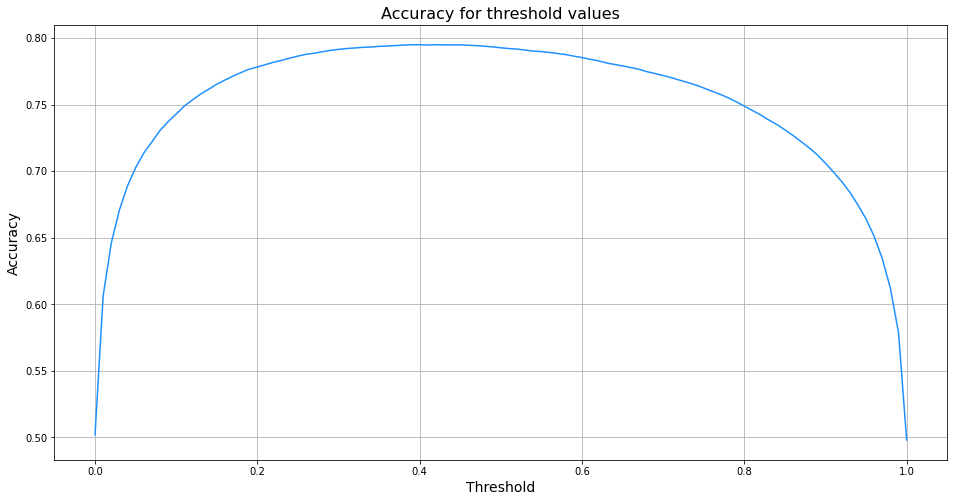

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds, accuracies, color="dodgerblue")
plt.title("Accuracy for threshold values", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid()
plt.show()

In [ ]:
# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79     49804
           1       0.80      0.79      0.80     50196

    accuracy                           0.79    100000
   macro avg       0.79      0.80      0.79    100000
weighted avg       0.80      0.79      0.79    100000



---
## Pretrained Word Embeddings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)

# read dataset
data = pd.read_parquet("drive/MyDrive/colab-data/pre-processed-tweets.parquet")

# tweet is the input and sentiment is the target
X = np.array(data["tweet"].tolist())
y = np.array(data["sentiment"].tolist())

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

# constants definition
VOCAB_SIZE = 300000
MAX_LENGTH = 64
EMBEDDING_SIZE = 100

# layer to encode text
encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)
encoder.adapt(X_train)

NUM_TOKENS = len(encoder.get_vocabulary())

print(f"Found {NUM_TOKENS} tokens.")

# load word embedding dict
path_to_glove_file = f"drive/MyDrive/colab-data/glove.twitter.27B.{EMBEDDING_SIZE}d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_SIZE))
for i, word in enumerate(encoder.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Hit {hits} words ({misses} misses) - {(hits * 100 / (hits+misses)):.2f}%")

model = Sequential(
    [
        encoder,
        Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=EMBEDDING_SIZE,
            mask_zero=True,
            embeddings_initializer=Constant(embedding_matrix), # initialize embeddings using embedding matrix
            trainable=True,
        ),
        Bidirectional(LSTM(EMBEDDING_SIZE)),
        Dense(MAX_LENGTH, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=3)
y_pred = model.predict(X_test)

Found 186302 tokens.
Found 1193514 word vectors.
Hit 75349 words (110953 misses) - 0.40%
Epoch 1/3
5625/5625 [==============================] - 1127s 194ms/step - loss: 0.4562 - accuracy: 0.7829 - val_loss: 0.4008 - val_accuracy: 0.8201
Epoch 2/3
5625/5625 [==============================] - 1087s 193ms/step - loss: 0.3275 - accuracy: 0.8579 - val_loss: 0.4222 - val_accuracy: 0.8094
Epoch 3/3
5625/5625 [==============================] - 1090s 194ms/step - loss: 0.2328 - accuracy: 0.9020 - val_loss: 0.4815 - val_accuracy: 0.8010


#### Threshold analysis

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

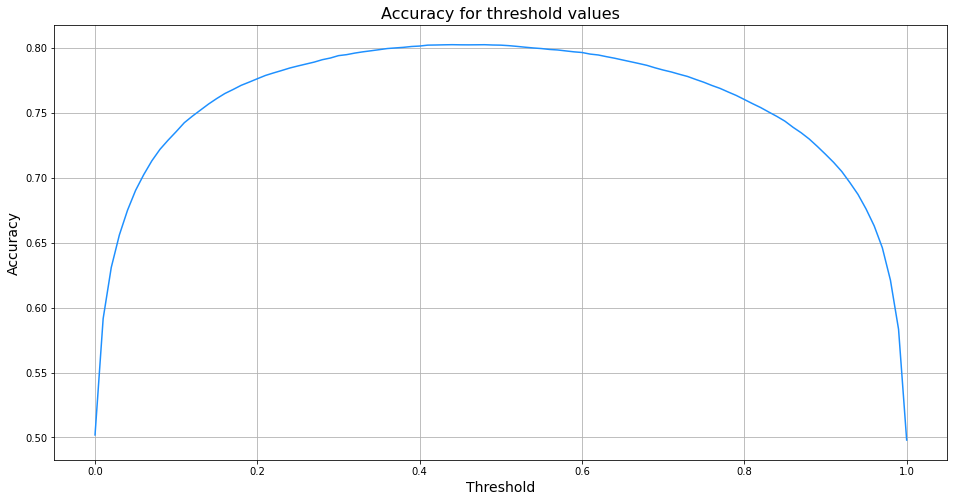

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds, accuracies, color="dodgerblue")
plt.title("Accuracy for threshold values", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid()
plt.show()

In [ ]:
# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     49804
           1       0.80      0.81      0.80     50196

    accuracy                           0.80    100000
   macro avg       0.80      0.80      0.80    100000
weighted avg       0.80      0.80      0.80    100000



---
## Bert based classifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Model

# read dataset
data = pd.read_parquet("drive/MyDrive/colab-data/pre-processed-tweets.parquet")

# tweet is the input and sentiment is the target
X = np.array(data["tweet"].tolist())
y = np.array(data["sentiment"].tolist())

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

# pre-trained bert-based utils
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# define model
text_input = Input(shape=(), dtype=tf.string, name="text")

# pre-trained layers
encoder_inputs = hub.KerasLayer(tfhub_handle_preprocess, name="preprocessing")(
    text_input
)
outputs = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name="BERT_encoder")(
    encoder_inputs
)
net = outputs["pooled_output"]

# last custom layers
drop = Dropout(0.1)(net)
dense = Dense(128)(drop)
out = Dense(1, activation="sigmoid")(dense)

model = Model(text_input, out)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=2)
y_pred = model.predict(X_test)

Epoch 1/2
5625/5625 [==============================] - 1573s 279ms/step - loss: 0.5820 - accuracy: 0.6933 - val_loss: 0.5483 - val_accuracy: 0.7251
Epoch 2/2
5625/5625 [==============================] - 1577s 280ms/step - loss: 0.5631 - accuracy: 0.7074 - val_loss: 0.5429 - val_accuracy: 0.7257


#### Threshold analysis

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

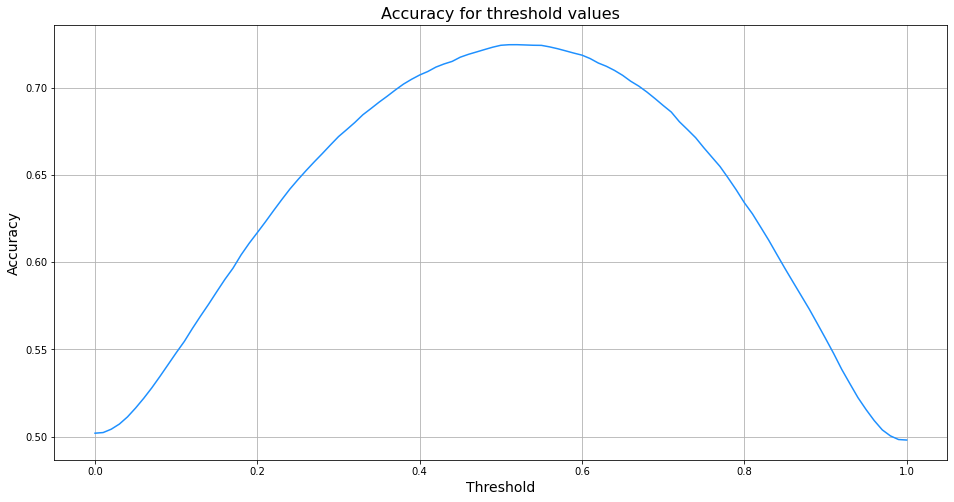

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds, accuracies, color="dodgerblue")
plt.title("Accuracy for threshold values", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid()
plt.show()

In [ ]:
# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     49804
           1       0.73      0.72      0.72     50196

    accuracy                           0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



## Sentence Embedding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sentence_transformers import SentenceTransformer

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

# read dataset
data = pd.read_parquet("drive/MyDrive/colab-data/pre-processed-tweets.parquet")

# tweet is the input and sentiment is the target
X = data["tweet"].tolist()
y = np.array(data["sentiment"].tolist())

# extract sentence (tweet) embedding
sentence_encoder = SentenceTransformer("distiluse-base-multilingual-cased-v2")
X = sentence_encoder.encode(X, show_progress_bar=True)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

# define model
inp = Input(shape=(512))
dense = Dense(128, activation="relu")(inp)
drop = Dropout(0.2)(dense)
dense = Dense(32, activation="relu")(drop)
out = Dense(1, activation="sigmoid")(dense)

clf = Model(inp, out)

clf.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model and predict test set
clf.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=3)
y_pred = clf.predict(X_test)

100%|██████████| 504M/504M [00:17<00:00, 28.4MB/s]



Epoch 1/3
5625/5625 [==============================] - 16s 2ms/step - loss: 0.4671 - accuracy: 0.7775 - val_loss: 0.4346 - val_accuracy: 0.7959
Epoch 2/3
5625/5625 [==============================] - 12s 2ms/step - loss: 0.4308 - accuracy: 0.7983 - val_loss: 0.4285 - val_accuracy: 0.7987
Epoch 3/3
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4196 - accuracy: 0.8056 - val_loss: 0.4277 - val_accuracy: 0.7988


#### Threshold analysis

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

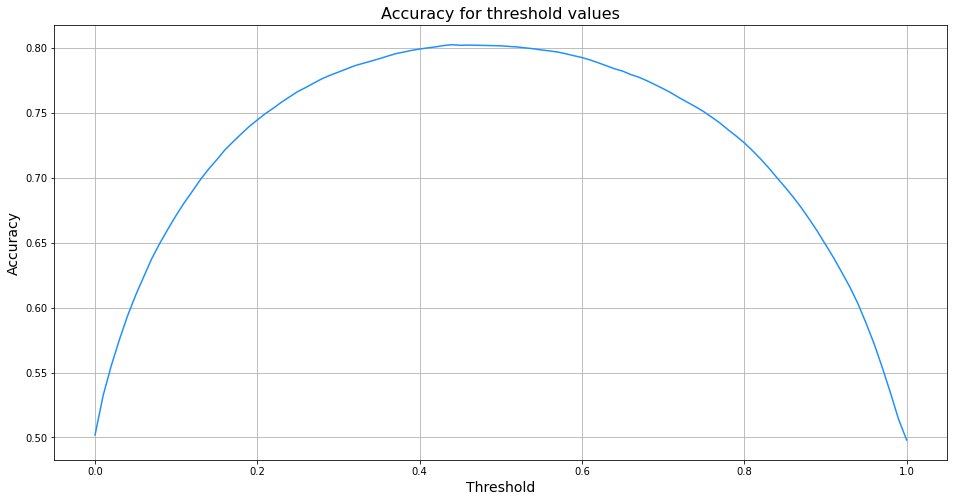

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds, accuracies, color="dodgerblue")
plt.title("Accuracy for threshold values", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid()
plt.show()

In [ ]:
# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     49804
           1       0.80      0.81      0.81     50196

    accuracy                           0.80    100000
   macro avg       0.80      0.80      0.80    100000
weighted avg       0.80      0.80      0.80    100000

